In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

from epi.example_eps import euler_sim, euler_sim_traj, load_W
import tensorflow as tf

npzfile = np.load('SV_mode.npz')
z_mode_SV = npzfile['z_mode1']

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "./"

In [2]:
lb_h = np.zeros((4,))
ub_h = np.ones((4,))

In [3]:
h = Parameter("h", 4, lb=lb_h, ub=ub_h)
parameters = [h]

sigma_eps = 0.0

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [4]:
# Define model
name = "V1Circuit"
model = Model(name, parameters)

In [6]:
X_INIT = tf.constant(np.random.normal(1.0, 0.01, (1, 4, 1)).astype(np.float32))

def ISN_coeff(h):
    h_E = h[:,0]
    h = h[:, :, None]
    W = 5.*load_W()

    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones((h.shape[0], 4, 1), dtype=tf.float32)
    x_init = _x_shape*X_INIT
    
    sigma_eps = 0.
    def f(y):
        #omega = tf.random.normal(h.shape, 0., 1.)
        #noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h) ** n)) / tau
    

    r_ss = euler_sim(f, x_init, dt, T)
    u_E = tf.tensordot(W[:,0,:], r_ss, [1,1])
    u_E = u_E[0,:] + h_E
    u_E = tf.nn.relu(u_E)
    isn_coeff = 1.-2.*(u_E)*W[:,0,0]
    
    return isn_coeff[:,None]


    
model.set_eps(ISN_coeff)

In [7]:
D = sum([param.D for param in model.parameters])
lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])

In [10]:
M = 1000
num_keep = 100

mean = [-.5]
std = [0.25]

def accept_inds(T_x, mean ,std):
    accept = np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0])
    return accept

fac = 3.

num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D), dtype=np.float32)
    for j in range(D):
        _z[:,j] = fac*np.random.uniform(lb[j], ub[j], (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)
    

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]



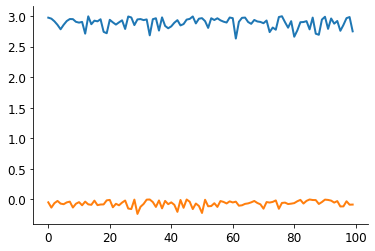

In [11]:
plt.plot(z[:,0])
plt.plot(T_x[:,0])

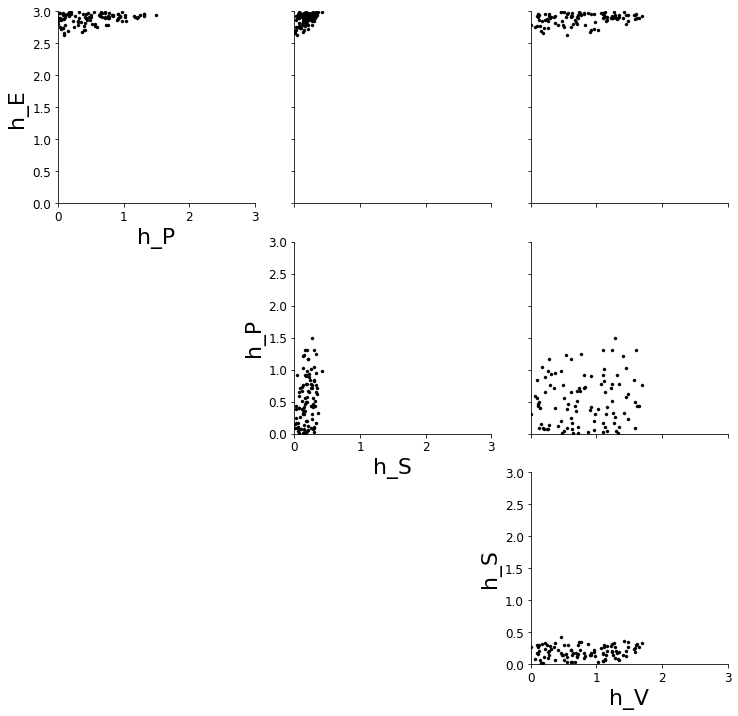

In [12]:
num_plot = 500
fontsize = 14

z_labels = ['h_%s' % alpha for alpha in neuron_inds.keys()]

fig = pairplot(z, range(4), z_labels,
               fontsize=22, outlier_stds=2, 
               lb=fac*lb_h, ub=fac*ub_h)

(23, 4) (23, 4)


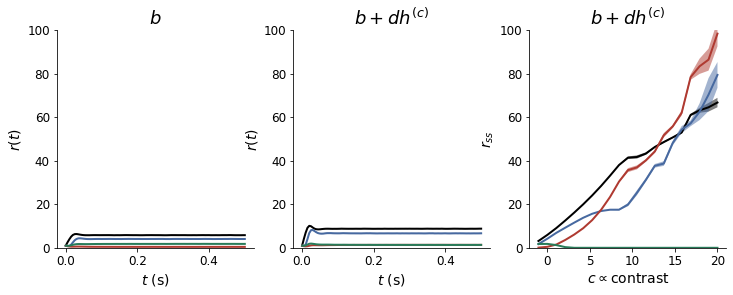

(23, 4) (23, 4)


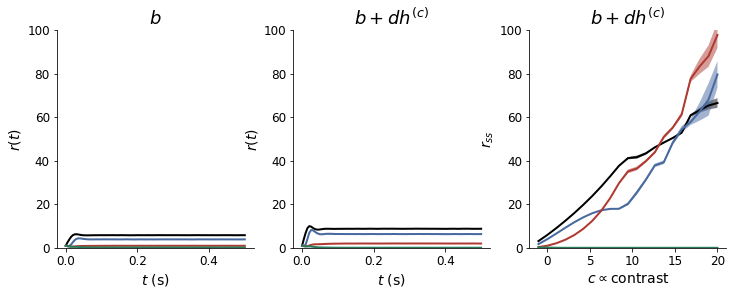

(23, 4) (23, 4)


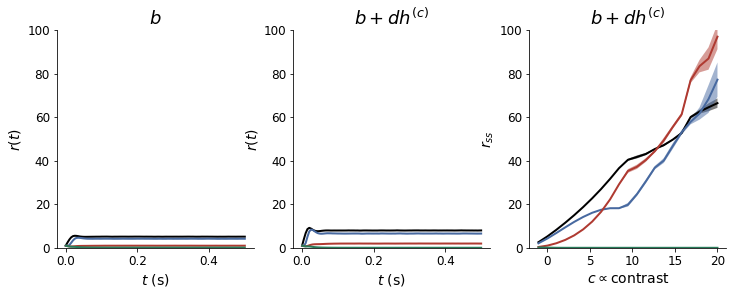

(23, 4) (23, 4)


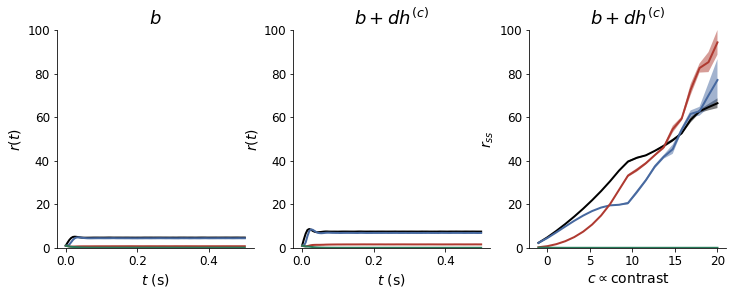

(23, 4) (23, 4)


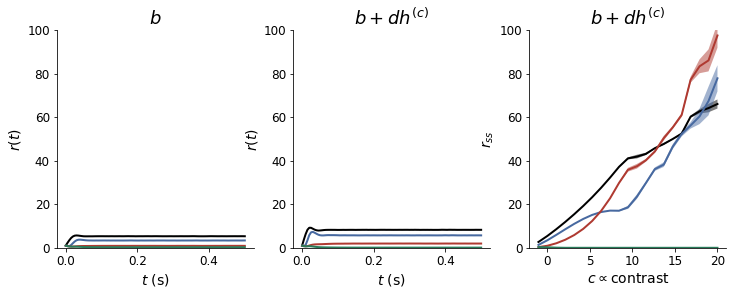

(23, 4) (23, 4)


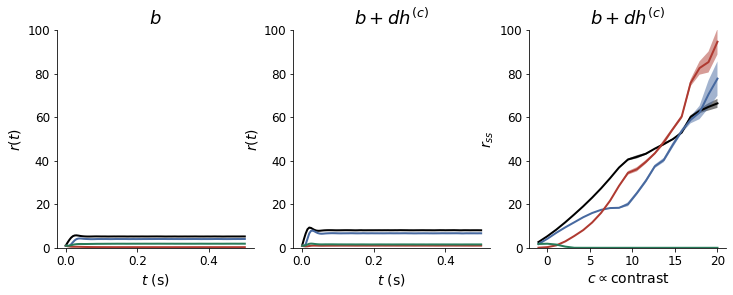

(23, 4) (23, 4)


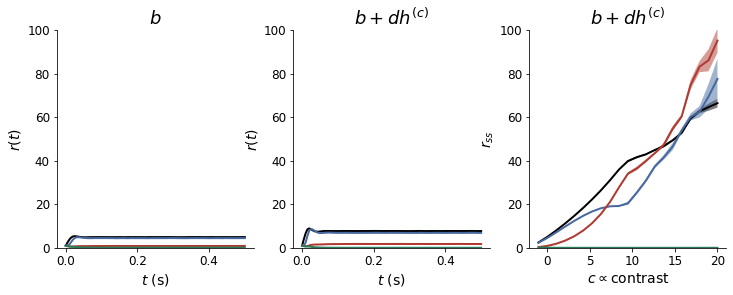

(23, 4) (23, 4)


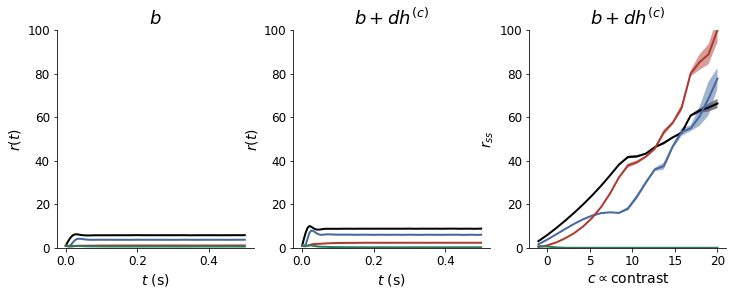

(23, 4) (23, 4)


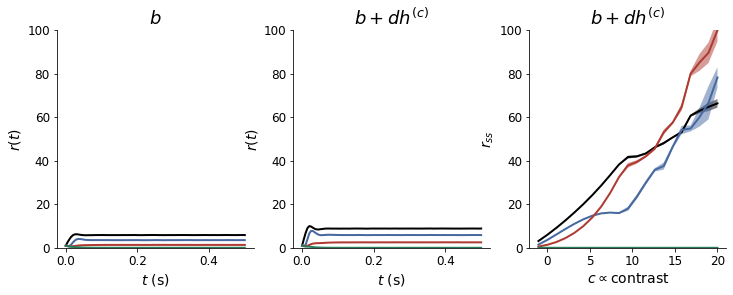

(23, 4) (23, 4)


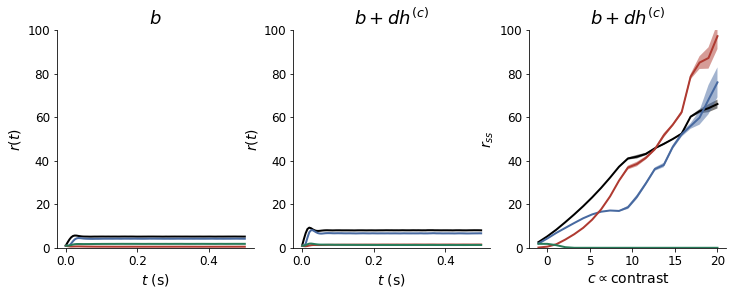

In [21]:
for i in range(10):
    _,_,_ = plot_sims(z[i], M=200, gamma_lims=(-1, 20.), ylim=(0,100))
    plt.show()

In [22]:
print(load_W())

tf.Tensor(
[[[ 0.0576  -0.19728 -0.13144 -0.02436]
  [ 0.58855 -0.30668 -0.4285  -0.0036 ]
  [ 0.15652 -0.0126  -0.0123  -0.2    ]
  [ 0.13755 -0.0902  -0.4004  -0.01036]]], shape=(1, 4, 4), dtype=float32)


In [14]:
from epi.example_eps import V1_sim

def plot_sims(z, sigma_eps=0.05, gamma_lims=(-1,2), M=200, subscript=None, fontsize=14, ylim=None):
    h = z[:4][None,:]

    dh = tf.concat((tf.ones((M,1)), tf.zeros((M,1))), axis=1)
    #dh = tf.concat((tf.zeros((M,1)), tf.ones((M,1))), axis=1)

    _h = np.tile(h, [M, 1])
    r_ts = []
    gammas = np.concatenate((np.array([0,1,]), np.linspace(gamma_lims[0], gamma_lims[1], 21)))
    for gamma in gammas:
        r_ts.append(V1_sim(_h, gamma*dh))
    r_ts = np.array(r_ts)
    mean_r_ts = np.mean(r_ts, axis=1)
    std_r_ts = np.std(r_ts, axis=1)

    _mean_r = np.mean(r_ts[:,:,:,50:], axis=3)
    mean_r = np.mean(_mean_r, axis=1)
    std_r = np.std(_mean_r, axis=1)
    
    print(mean_r.shape, std_r.shape)
    
    t = 0.005*np.arange(101)
    fig, axs = plt.subplots(1,3, figsize=(12,4))

    for i in range(4):
        axs[0].plot(t, mean_r_ts[0,i,:], c=colors[i])
        axs[0].fill_between(t, 
                            mean_r_ts[0,i,:]-std_r_ts[0,i,:],
                            mean_r_ts[0,i,:]+std_r_ts[0,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[1].plot(t, mean_r_ts[1,i,:], c=colors[i])
        axs[1].fill_between(t, 
                            mean_r_ts[1,i,:]-std_r_ts[1,i,:],
                            mean_r_ts[1,i,:]+std_r_ts[1,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[2].plot(gammas[2:], mean_r[2:,i], c=colors[i])
        axs[2].fill_between(gammas[2:], 
                            mean_r[2:,i]-std_r[2:,i],
                            mean_r[2:,i]+std_r[2:,i],
                            facecolor=colors[i], alpha=0.5)
        
    axs[0].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[0].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[0].set_title(r'$b_%d$' % subscript, fontsize=fontsize+4)
    else:
        axs[0].set_title(r'$b$', fontsize=fontsize+4)
    
    axs[1].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[1].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[1].set_title(r'$b_%d + dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[1].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
    
    axs[2].set_xlabel(r"$c \propto $contrast", fontsize=fontsize)
    axs[2].set_ylabel(r'$r_{ss}$', fontsize=fontsize)
    if subscript is not None:
        axs[2].set_title(r'$b_%d + c dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[2].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
        
    if ylim is not None:
        for i in range(3):
            axs[i].set_ylim(ylim)

    return gammas[2:], mean_r_ts[2:], std_r_ts[2:]